In [580]:
import pandas as pd
import numpy as np
import os

# Perimeter

In [581]:
data = pd.read_parquet("../data/edited_data/modeling/data")

In [582]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528662 entries, tt0000009 to tt9916754
Data columns (total 46 columns):
averageRating_actor_min        278406 non-null float64
averageRating_actor_mean       278406 non-null float64
averageRating_actor_max        278406 non-null float64
averageRating_director_min     226021 non-null float64
averageRating_director_mean    226021 non-null float64
averageRating_director_max     226021 non-null float64
averageRating_genre_min        405768 non-null float64
averageRating_genre_mean       405768 non-null float64
averageRating_genre_max        405768 non-null float64
isAdult                        450695 non-null float64
runtimeMinutes                 311054 non-null object
age                            407858 non-null float64
genre_Action                   405768 non-null float64
genre_Adult                    405768 non-null float64
genre_Adventure                405768 non-null float64
genre_Animation                405768 non-null float64
genr

In [648]:
perimeter = data.drop(
    columns=[
        "ProductionBudget", 
        "primaryTitle"
    ], axis=1).dropna()
print(perimeter.shape)
#perimeter = data.drop(columns=["primaryTitle"], axis=1).dropna()

(125045, 44)


La feature "productionBudget" ne permet d'affiner le modèle - en plus de présenter un faible taux de remplissage

### Exploratory analysis

In [584]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

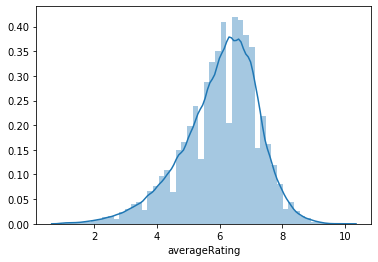

In [585]:
sns.distplot(perimeter.averageRating)

#### correlations

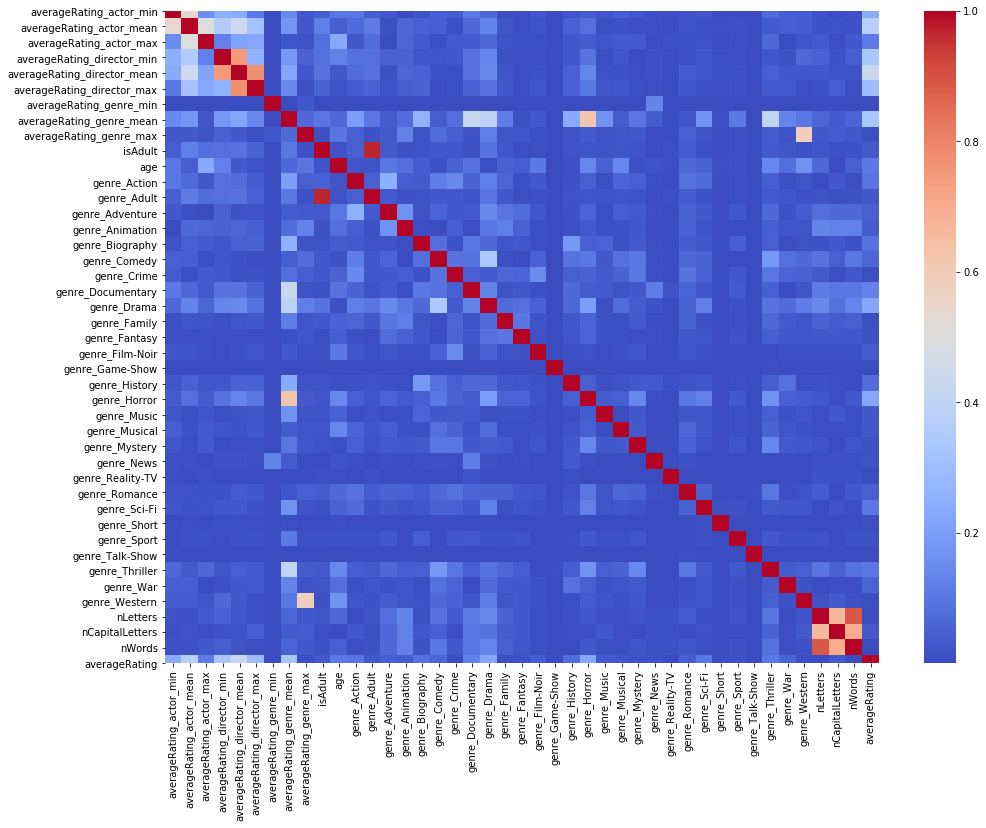

In [586]:
corr = np.abs(perimeter.corr())

fig = plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm")

<li>nLetters & nWords sont trop corrélés à la variable nCapitalLetters
<li>averageRating_director_mean trop corrélé à averageRating_director_min & averageRating_director_max

In [649]:
cols_corr_var = ["nLetters", "nWords", "averageRating_director_mean"]

Variables peu corrélées à la cible (seuil à .05)

In [650]:
corr_averageRating = corr[["averageRating"]].sort_values(by="averageRating", ascending=False)
cols_corr_drop = corr_averageRating[corr_averageRating.averageRating < .05].index.tolist()
print(cols_corr_drop)

['genre_Romance', 'genre_Adventure', 'genre_Animation', 'genre_Film-Noir', 'isAdult', 'nCapitalLetters', 'genre_Music', 'genre_Adult', 'genre_Musical', 'genre_News', 'genre_Fantasy', 'genre_Sport', 'genre_Mystery', 'genre_Family', 'averageRating_genre_max', 'genre_Western', 'genre_Crime', 'genre_Short', 'genre_Reality-TV', 'genre_Talk-Show', 'nWords', 'genre_Game-Show', 'nLetters', 'averageRating_genre_min']


In [652]:
cols_drop = list(set(cols_corr_var) | set(cols_corr_drop))

In [653]:
perimeter = perimeter.drop(columns=cols_drop, axis=1)

## modeling

### Linear model

In [654]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [655]:
X = perimeter.drop(columns=["averageRating"], axis=1)
y = perimeter.averageRating

In [656]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125045 entries, tt0001285 to tt9914286
Data columns (total 18 columns):
averageRating_actor_min       125045 non-null float64
averageRating_actor_mean      125045 non-null float64
averageRating_actor_max       125045 non-null float64
averageRating_director_min    125045 non-null float64
averageRating_director_max    125045 non-null float64
averageRating_genre_mean      125045 non-null float64
runtimeMinutes                125045 non-null object
age                           125045 non-null float64
genre_Action                  125045 non-null float64
genre_Biography               125045 non-null float64
genre_Comedy                  125045 non-null float64
genre_Documentary             125045 non-null float64
genre_Drama                   125045 non-null float64
genre_History                 125045 non-null float64
genre_Horror                  125045 non-null float64
genre_Sci-Fi                  125045 non-null float64
genre_Thriller      

In [632]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [633]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [634]:
from sklearn.linear_model import LinearRegression

In [635]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [636]:
lr.score(X_test_scaled, y_test)

0.3128634891197251

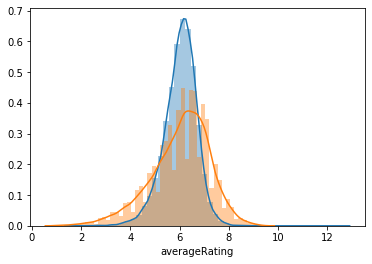

In [637]:
sns.distplot(lr.predict(X_test_scaled))
sns.distplot(y_test)

Le rating prédit est très centré sur la moyenne, avec un écart type faible par rapport à l'observé : difficulté à prédire les mauvaises et très bonne notes
<br>Entre d'autres termes, on prédit la moyenne

### Classifier

#### preprocess
On choisit ici un découpage de la variable cible. Il s'agit parmis tant d'autres (plusieurs ont été testés) 

In [658]:
m = perimeter.averageRating.mean()
sigma = perimeter.averageRating.std()

def get_rate_classes(rate):
    if rate < m - sigma:
        return 0
    if rate < m:
        return 1
    if rate < m + sigma:
        return 2
    else:
        return 3
    
print("bounds: {}, {}, {}".format(m-sigma, m, m+sigma))


perimeter["target"] = perimeter.averageRating.apply(get_rate_classes)

bounds: 4.824295922600266, 6.029055939861458, 7.2338159571226495


on scale les données... étape peu utile dans le cas présent, elle l'était cependant lors l'utilisation de la donnée productionBudget

In [661]:
X = perimeter.drop(columns=["averageRating", "target"], axis=1)
y = perimeter.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

#### modeling
On teste ici deux modèles afin de prédire les classes : 
<li>une régression logistique multinomiale
<li>une random forest

In [640]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [641]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.56      0.37      0.44      5983
           1       0.42      0.23      0.29     10864
           2       0.50      0.86      0.63     15828
           3       0.53      0.07      0.12      4839

    accuracy                           0.49     37514
   macro avg       0.50      0.38      0.37     37514
weighted avg       0.49      0.49      0.44     37514



0.49 d'accuracy, bien, mais pas transcendant. Le recall sur la classe 3 (meilleurs films) est relativement faible

In [662]:
clf = RandomForestClassifier()
param_grid = {
    'max_depth': [10],
    'n_estimators': [100]
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2)

grid.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.3s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=100, total=   4.4s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [663]:
y_pred = grid.predict(X_test_scaled)

In [664]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.41      0.48      5983
           1       0.43      0.31      0.36     10864
           2       0.52      0.81      0.64     15828
           3       0.58      0.11      0.18      4839

    accuracy                           0.51     37514
   macro avg       0.53      0.41      0.41     37514
weighted avg       0.51      0.51      0.47     37514



0.51 d'accuracy. Mieux, mais toujours pas transcendant. Le recall sur la classe 3 (meilleurs films) est plus élevé, et le modèle est globalement meilleur pour prédicre les extrèmes

In [645]:
pd.crosstab(y_test, grid.predict(X_test_scaled))

col_0,0,1,2,3
target,,,,
0,2440,1901,1625,17
1,1170,3370,6277,47
2,458,2149,12947,274
3,93,304,3928,514


In [646]:
contributions = dict(zip(X_train.columns.tolist(), grid.best_estimator_.feature_importances_))
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
averageRating_actor_mean,0.223466
averageRating_director_min,0.149960
averageRating_genre_mean,0.129928
averageRating_director_max,0.111700
age,0.092866
runtimeMinutes,0.090423
averageRating_actor_min,0.062249
averageRating_actor_max,0.034795
genre_Drama,0.031426
genre_Horror,0.031276
